# Import Libaray

In [1]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(leaps)
library(broom)
set.seed(123)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
✔ purrr     1.0.2     ✔ tibble    3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked fro

In [2]:
diabetes <- read.csv("data/diabetes.csv")
head(diabetes)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,0,0,25.6,0.201,30,0


# Introduction

Diabetes affects approximately 830 million people worldwide, with the majority living in low- and middle-income countries, and more than half live untreated (_Diabetes_, 2024). This poses a significant health concern because Type 2 diabetes, the most common type, can increase the risk of developing complications, such as cardiovascular disease, stroke, and chronic kidney disease (_Diabetes complications and risks_, 2024). 

One disproportionately affected population is the Pima Indians, an indigenous community residing in a hot desert environment in Arizona, USA, who have faced significant challenges in accessing adequate healthcare due to poor resources, low income, and unfavourable economic conditions, leading to delayed detection and inadequate management of chronic illnesses, particularly diabetes (Guan et al., 2024). Systematic glucose-tolerance tests conducted on this population revealed that the prevalence of diabetes mellitus is 50% among individuals aged 35 and older, making it the highest prevalence of diabetes ever recorded (Bennett et al., 2003). Additionally, earlier research by Knowler et al. (1993) on the Pima Indians showed that worsening glucose tolerance, especially in those with impaired glucose tolerance, is associated with "markedly higher incidence rates of diabetes". 

Therefore, given the increasing number of incidents and the fatal complications associated with untreated diabetes, continued research into the identification and prevention of diabetes is critical for improving health among the Pima Indians and other high-risk populations.

To explore this further, our project focuses on predicting diabetes using health metrics, such as Glucose and BMI, from a dataset provided by the National Institute of Diabetes and Digestive and Kidney Diseases, made up female patients aged 21+ of Pima Indian heritage, a group with a notably high prevalence of diabetes. 

Our primary question is: Which variables best predict diabetes, and to what extent do these metrics contribute to the likelihood of a diagnosis? Additionally, we aim to explore which specific predictors have the strongest association with diabetes, and how do these align with existing findings. 

To answer these questions, we will use logistic regression for binary classifications, exploring valuable insights into diabetes risk factors and and creating a model identifying the most significant predictors.

# Methods and Results

## EDA (Exploratory Data Analysis)

In [3]:
# Main developer: Luna 
# view the number of missing values for each variable
missing_values <- colSums(is.na(diabetes))
missing_values 

Pregnancies                  Glucose            BloodPressure 
                       0                        0                        0 
           SkinThickness                  Insulin                      BMI 
                       0                        0                        0 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0

After viewing missing_values, we can see that there are no missing values for any variable.

However, when we viewed some rows with head(diabetes), there were rows with zero values. 
- The presence of zeros in the dataset may indicate placeholders for missing data, as these values of certain health metrics generally shouldn’t be zero in health data, such as Glucose and Insulin; so, it’s reasonable to consider these zeros as placeholders for missing data. 
- If these are left in the model without treatment, it could lead to bias, especially in a logistic regression model sensitive to extreme values, by skewing distributions (i.e. falsely lower Insulin averages) and weaken the model’s predictive power.

Therefore, we can similarly check for such rows:

In [4]:
# Main developer: Luna 
# these columns are measurements which are generally unlikely to have 0 values (for instance unlike Pregnancies)
columns_with_zeros <- c("Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI")

zero_counts <- colSums(diabetes[columns_with_zeros] == 0)
zero_counts

Glucose BloodPressure SkinThickness       Insulin           BMI 
            5            35           227           374            11

We can now treat these zeros in these key predictor columns as missing values.

I decided to exclude rows with zero values, as these values could distort the analysis.
- _It's worthy to note that a possible issue with this method is that this might reduce our dataset size._

In [5]:
# Main developer: Luna 
# converting the zero values to NA
diabetes2 <- diabetes |>
    mutate_at(vars(all_of(columns_with_zeros)), ~na_if(., 0))

# dropping rows with NA
diabetes_cleaned <- diabetes2 |> drop_na(all_of(columns_with_zeros))
head(diabetes_cleaned)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,1,89,66,23,94,28.1,0.167,21,0
2,0,137,40,35,168,43.1,2.288,33,1
3,3,78,50,32,88,31.0,0.248,26,1
4,2,197,70,45,543,30.5,0.158,53,1
5,1,189,60,23,846,30.1,0.398,59,1
6,5,166,72,19,175,25.8,0.587,51,1


In [6]:
# Main developer: Luna 
# convert Outcome to a factor with levels "0" and "1"
diabetes_cleaned$Outcome <- factor(diabetes_cleaned$Outcome, levels = c(0, 1), labels = c("0", "1"))

# verify and check levels
str(diabetes_cleaned)
levels(diabetes_cleaned$Outcome)

'data.frame':	392 obs. of  9 variables:
 $ Pregnancies             : int  1 0 3 2 1 5 0 1 1 3 ...
 $ Glucose                 : int  89 137 78 197 189 166 118 103 115 126 ...
 $ BloodPressure           : int  66 40 50 70 60 72 84 30 70 88 ...
 $ SkinThickness           : int  23 35 32 45 23 19 47 38 30 41 ...
 $ Insulin                 : int  94 168 88 543 846 175 230 83 96 235 ...
 $ BMI                     : num  28.1 43.1 31 30.5 30.1 25.8 45.8 43.3 34.6 39.3 ...
 $ DiabetesPedigreeFunction: num  0.167 2.288 0.248 0.158 0.398 ...
 $ Age                     : int  21 33 26 53 59 51 31 33 32 27 ...
 $ Outcome                 : Factor w/ 2 levels "0","1": 1 2 2 2 2 2 2 1 2 1 ...


[1] "0" "1"

Lastly, viewing summary statistics allows us to gauge potential outliers.

In [7]:
# Main developer: Luna 
summary(diabetes_cleaned)

  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   : 56.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.:21.00  
 Median : 2.000   Median :119.0   Median : 70.00   Median :29.00  
 Mean   : 3.301   Mean   :122.6   Mean   : 70.66   Mean   :29.15  
 3rd Qu.: 5.000   3rd Qu.:143.0   3rd Qu.: 78.00   3rd Qu.:37.00  
 Max.   :17.000   Max.   :198.0   Max.   :110.00   Max.   :63.00  
    Insulin            BMI        DiabetesPedigreeFunction      Age       
 Min.   : 14.00   Min.   :18.20   Min.   :0.0850           Min.   :21.00  
 1st Qu.: 76.75   1st Qu.:28.40   1st Qu.:0.2697           1st Qu.:23.00  
 Median :125.50   Median :33.20   Median :0.4495           Median :27.00  
 Mean   :156.06   Mean   :33.09   Mean   :0.5230           Mean   :30.86  
 3rd Qu.:190.00   3rd Qu.:37.10   3rd Qu.:0.6870           3rd Qu.:36.00  
 Max.   :846.00   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
 Outco

In [8]:
# Main developer: Luna 

# calculate the IQR bounds for each column individually
Q1_bmi <- quantile(diabetes_cleaned$BMI, 0.25, na.rm = TRUE)
Q3_bmi <- quantile(diabetes_cleaned$BMI, 0.75, na.rm = TRUE)
IQR_bmi <- Q3_bmi - Q1_bmi

Q1_bp <- quantile(diabetes_cleaned$BloodPressure, 0.25, na.rm = TRUE)
Q3_bp <- quantile(diabetes_cleaned$BloodPressure, 0.75, na.rm = TRUE)
IQR_bp <- Q3_bp - Q1_bp

Q1_glucose <- quantile(diabetes_cleaned$Glucose, 0.25, na.rm = TRUE)
Q3_glucose <- quantile(diabetes_cleaned$Glucose, 0.75, na.rm = TRUE)
IQR_glucose <- Q3_glucose - Q1_glucose

Q1_insulin <- quantile(diabetes_cleaned$Insulin, 0.25, na.rm = TRUE)
Q3_insulin <- quantile(diabetes_cleaned$Insulin, 0.75, na.rm = TRUE)
IQR_insulin <- Q3_insulin - Q1_insulin

# filter rows based on the IQR bounds for each column
diabetes_clean <- diabetes_cleaned %>%
  filter(Glucose >= (Q1_glucose - 1.5 * IQR_glucose) & Glucose <= (Q3_glucose + 1.5 * IQR_glucose),
         BloodPressure >= (Q1_bp - 1.5 * IQR_bp) & BloodPressure <= (Q3_bp + 1.5 * IQR_bp),
         Insulin >= (Q1_insulin - 1.5 * IQR_insulin) & Insulin <= (Q3_insulin + 1.5 * IQR_insulin),
         BMI >= (Q1_bmi - 1.5 * IQR_bmi) & BMI <= (Q3_bmi + 1.5 * IQR_bmi))

In [9]:
# Main developer: Farrel

# Divide the data into even number for diabetes and non diabetes
# Balance the data such that the ratio between Outcome value of 0 and 1 is the same
count_outcome_0 <- sum(diabetes_clean$Outcome == 0)
count_outcome_1 <- sum(diabetes_clean$Outcome == 1)
count_outcome_minimum <- min(count_outcome_0, count_outcome_1)

diabetes_balanced <- diabetes_clean %>%
  group_by(Outcome) %>%
  sample_n(count_outcome_minimum)

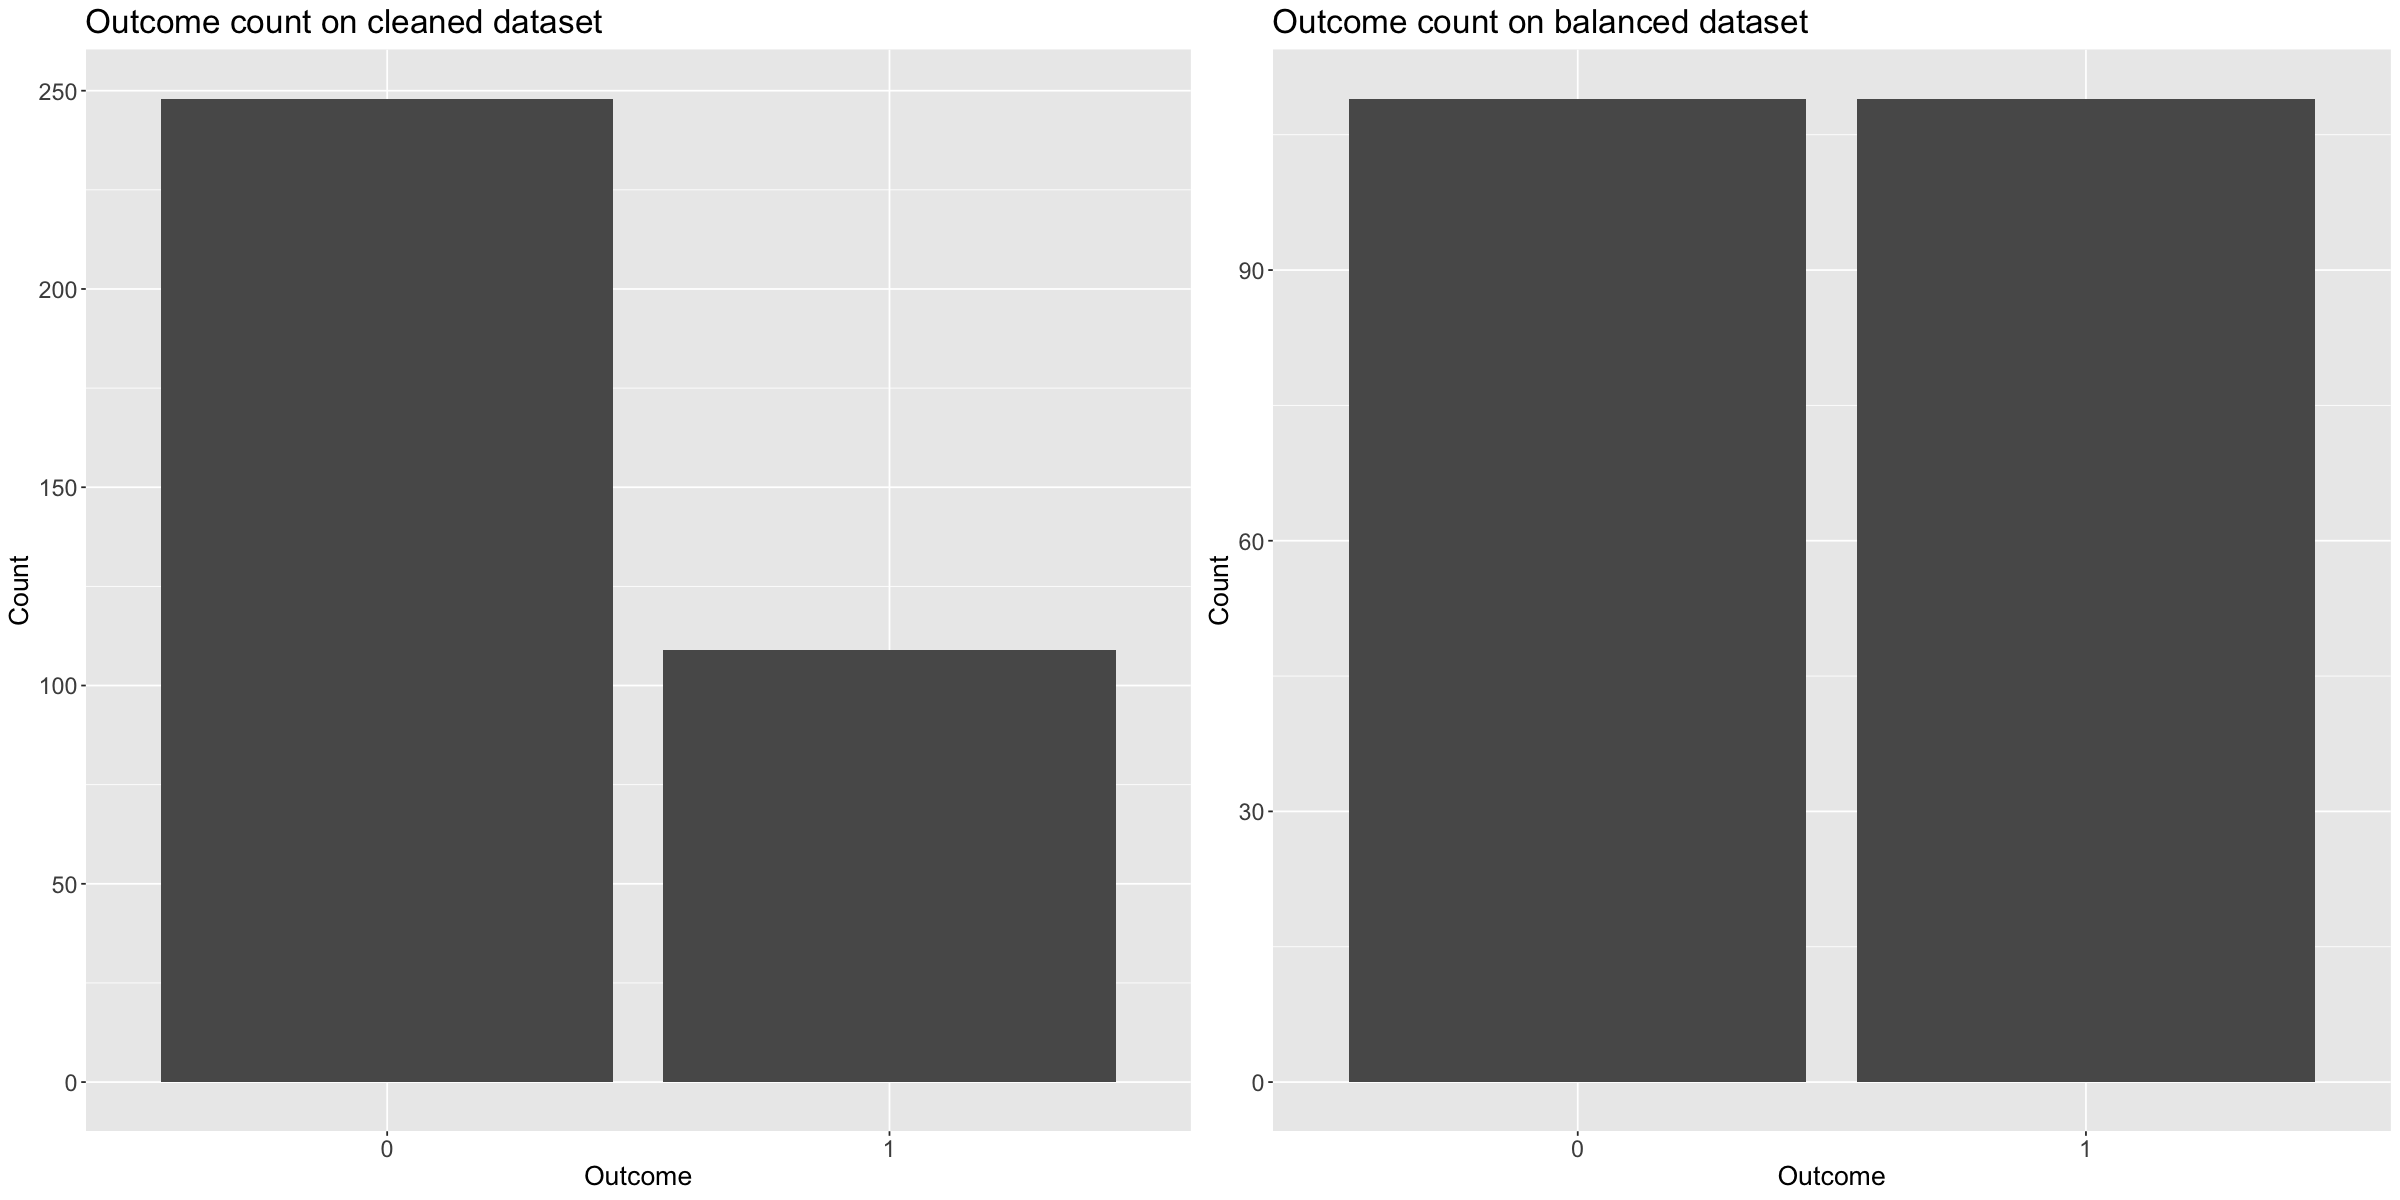

In [10]:
# Main developer: Farrel
# Contributor: Yulin (rearrange plot)

# Visualized the total number of each outcome in diabetes_clean and diabetes_balanced
options(repr.plot.width = 20, repr.plot.height = 10)

plot1 <- ggplot(diabetes_clean, aes(x = Outcome)) +
  geom_bar() +
  labs(x = "Outcome", y = "Count", title = "Outcome count on cleaned dataset")+
  theme(
    plot.title = element_text(size = 20),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text = element_text(size = 14)
  )

plot2 <- ggplot(diabetes_balanced, aes(x = Outcome)) +
  geom_bar() +
  labs(x = "Outcome", y = "Count", title = "Outcome count on balanced dataset")+
  theme(
    plot.title = element_text(size = 20),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text = element_text(size = 14)
  )

# Arrange the plots side by side
grid.arrange(plot1, plot2, ncol = 2)

Here, we decided to cut the data furthermore to balanced the data. Balancing the data would lead to reduced bias and ensure that the model weight balancly.

In [11]:
# Main developer: Yulin 
# Contributor: Farrel (Use the balanced data)

set.seed(123)

diabetes_sample <-
    diabetes_balanced %>%
    mutate(id = row_number())

training_diabetes <- 
    diabetes_sample %>%
    slice_sample(prop = 0.60)

testing_diabetes <- 
    diabetes_sample %>% 
    anti_join(training_diabetes, by = "id") %>%
    select(-id)

training_diabetes <-
    training_diabetes |>
    select(-id)

count(training_diabetes)
count(testing_diabetes)

Outcome,n
<fct>,<int>
0,65
1,65


Outcome,n
<fct>,<int>
0,21
1,21


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


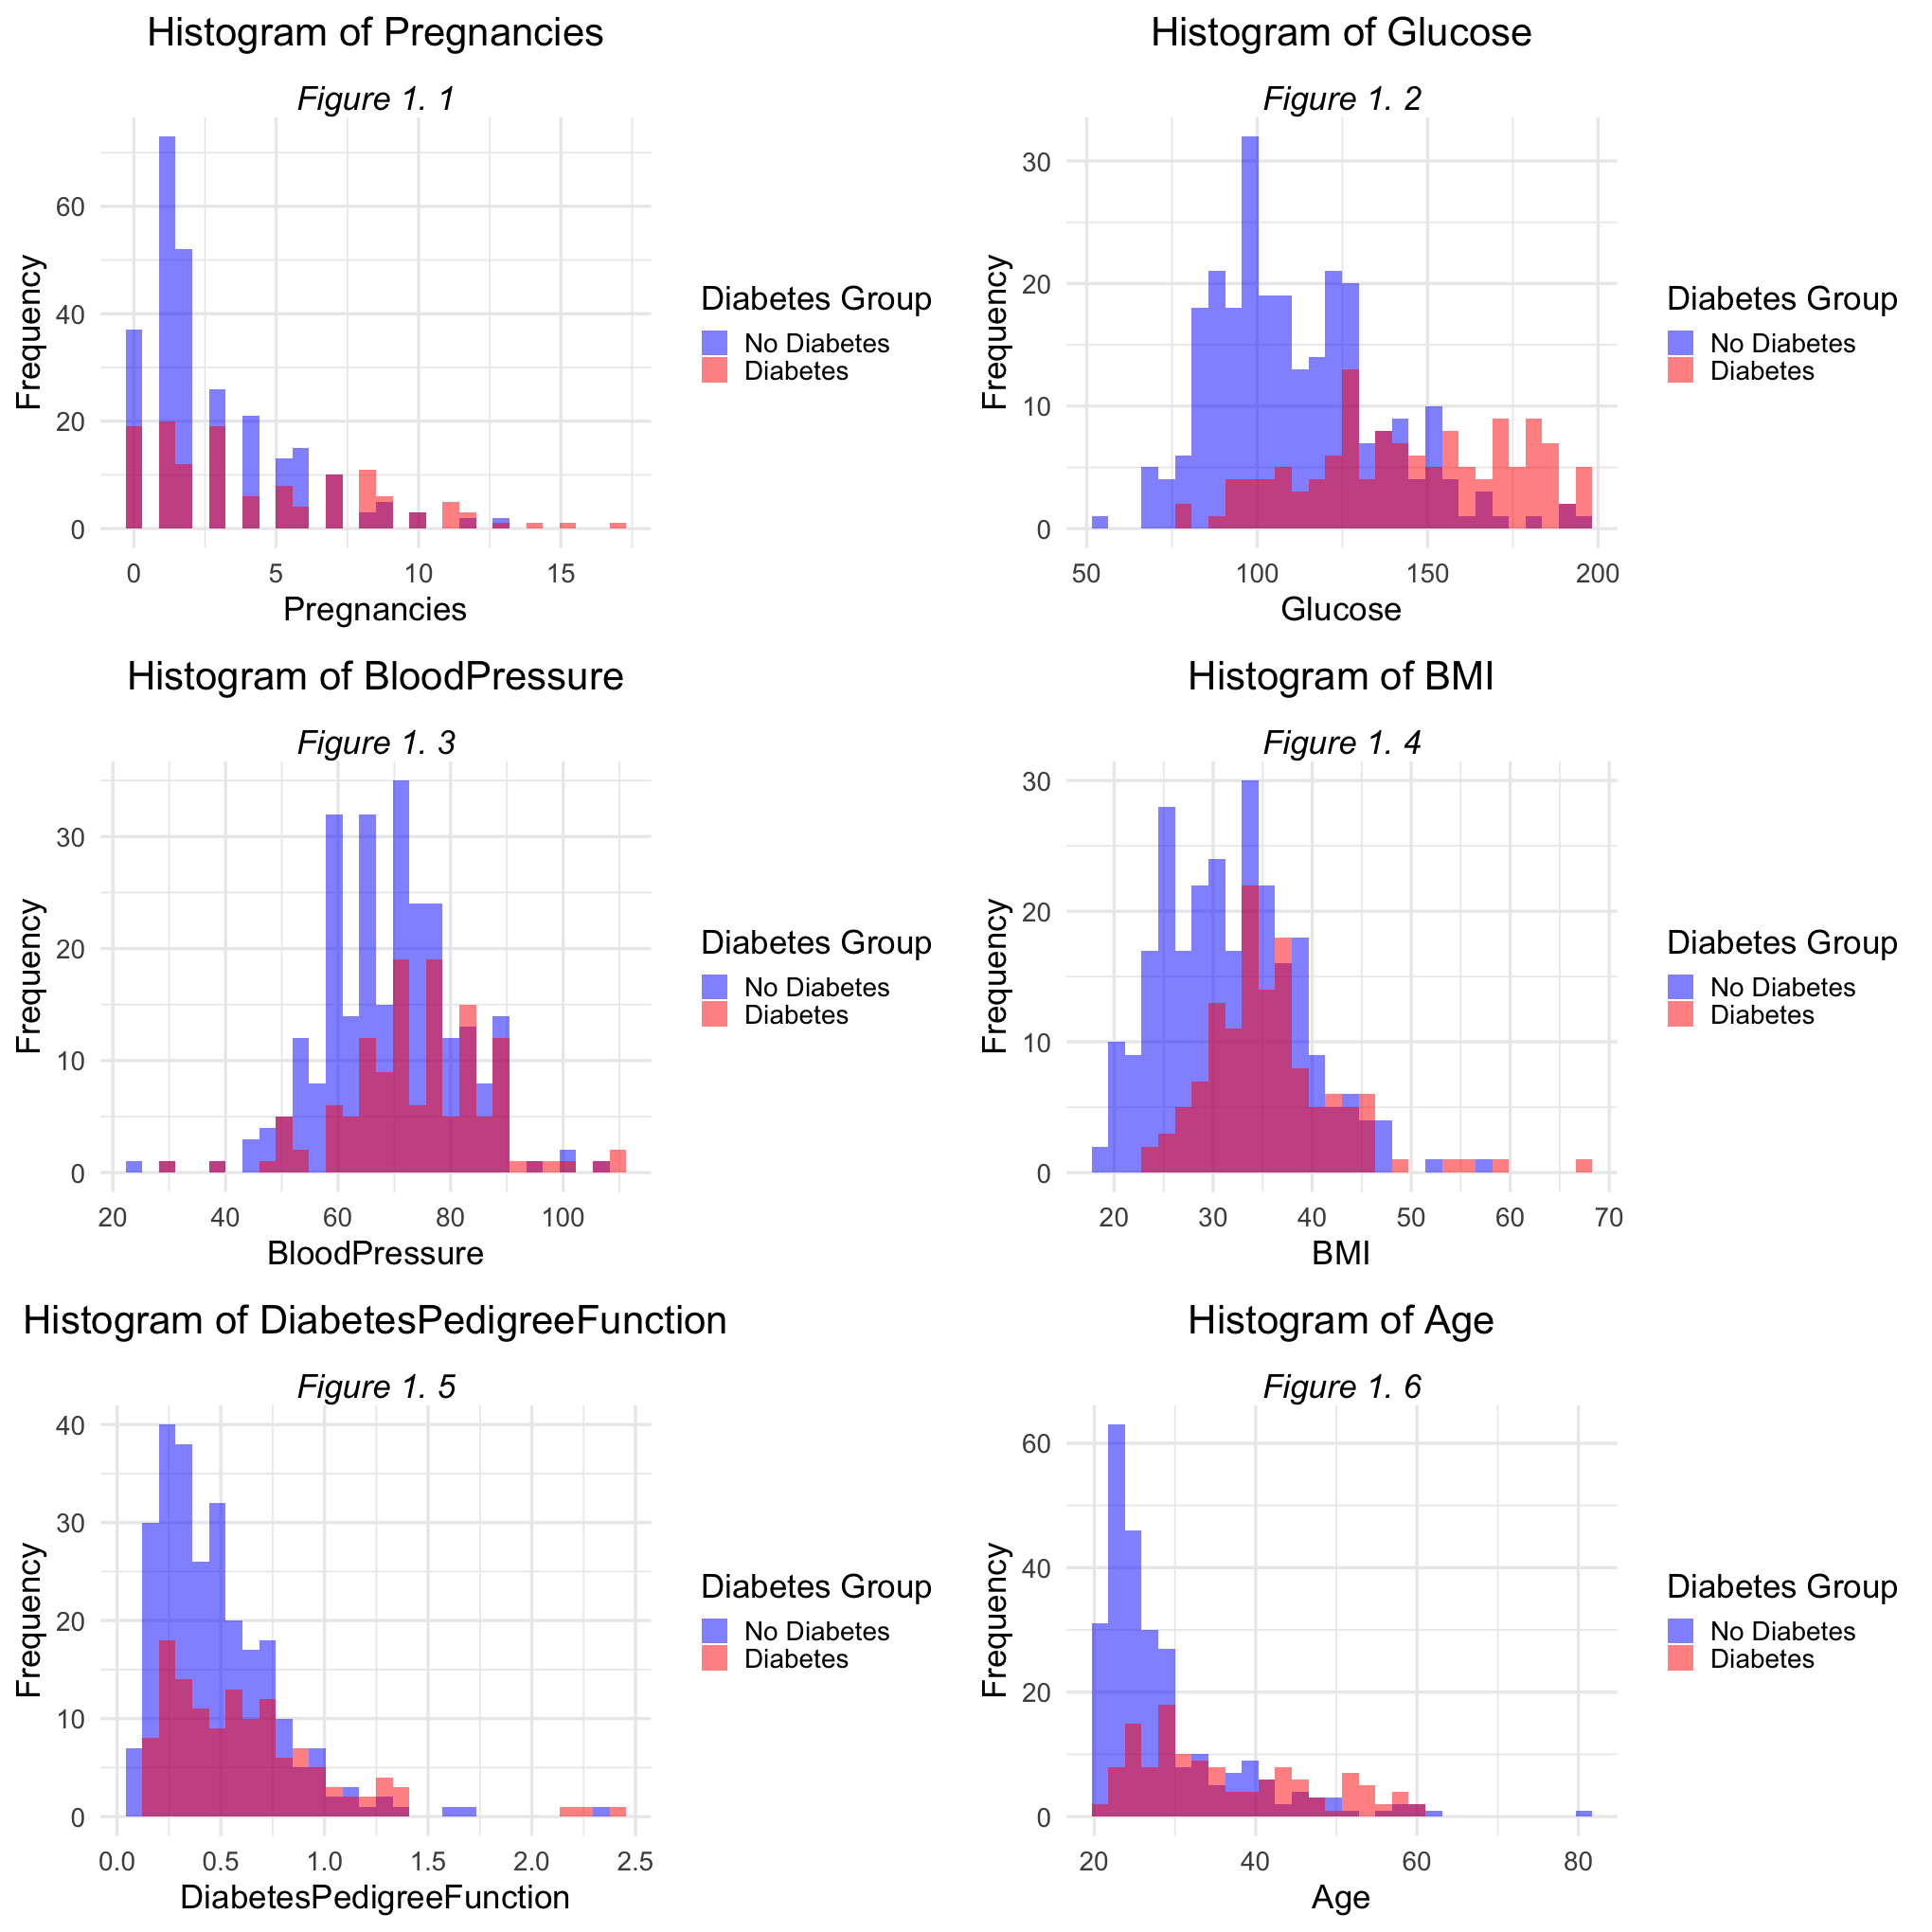

In [12]:
# Main developer: Yulin 
# Edited By Josh To add figure numbers
options(repr.plot.width = 17, repr.plot.height = 17)
numeric_cols <- c("Pregnancies", "Glucose", "BloodPressure", "BMI", "DiabetesPedigreeFunction", "Age")
my_list <- list()

for (i in seq_along(numeric_cols)) {
  feat <- numeric_cols[i]
  feat_plot <- ggplot(diabetes_cleaned) + 
    geom_histogram(aes_string(x = feat, fill = "factor(Outcome)"), bins = 30, alpha = 0.5, position = "identity") +
    labs(
      title = paste("Histogram of", feat), 
      subtitle = paste("Figure 1.", i),
      x = feat, 
      y = "Frequency"
    ) +
    scale_fill_manual(values = c("blue", "red"), labels = c("No Diabetes", "Diabetes")) +
    guides(fill = guide_legend(title = "Diabetes Group")) +
    theme_minimal(base_size = 21) + 
    theme(
      plot.title = element_text(hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5, face = "italic", margin = margin(t = 10))
    )
  my_list[[i]] <- feat_plot
}
do.call(grid.arrange,my_list)

### Preliminary Observations from Histograms

- **Pregnancies**: The distribution is right-skewed, with most values clustered around lower numbers. Patients with diabetes tend to have a higher number of pregnancies compared to those without diabetes.

- **Glucose**: There is a noticeable difference between the glucose levels of diabetic and non-diabetic patients. Diabetic patients generally have higher glucose levels, creating a clearer separation in the histogram.

- **Blood Pressure**: Both groups have similar distributions with a slight trend towards higher blood pressure in diabetic patients.

- **Skin Thickness**: Diabetic patients tend to have thicker skin measurements than non-diabetic patients.

- **Insulin**: Diabetic patients generally show a wider range of insulin values, with a tendency towards higher levels.

- **BMI**: Both groups show a right-skewed distribution, but diabetic patients tend to have higher BMI values on average compared to non-diabetic patients.

- **Diabetes Pedigree Function**: The distribution is right-skewed, with diabetic patients showing a slightly higher pedigree function, indicating a higher likelihood of diabetes based on family history.

- **Age**: The distribution is right-skewed, with a higher proportion of younger individuals. Diabetic patients tend to be older on average than non-diabetic patients.


## Modelling

In this report, we will approach the modelling stage which we are using the same dataset (balanced dataset) for different type of model, this report we explore:
- Default logistic regression
- Backward selection logistic regression
- Lasso (least absolute shrinkage and selection operator) regression
- Ridge regression

### Default Logistic Regression

In [13]:
# Main developer: Farrel
# Contributor: Yulin (rearrange plot)

options(repr.plot.width = 11, repr.plot.height = 11)
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)
# Fit the full model to Logistic Regression
full_diabetes_model <- glm(Outcome ~ .,
                            data = training_diabetes,
                            family = "binomial")

ROC_full_log <-
    roc(response = testing_diabetes$Outcome,
        predictor = predict(full_diabetes_model, type = "response", newdata=testing_diabetes))

diabetes_AUC_models <- 
    tibble(
        model = "ordinary",
        auc = as.numeric(ROC_full_log$auc))

summary(full_diabetes_model)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
glm(formula = Outcome ~ ., family = "binomial", data = training_diabetes)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.473e+01  2.916e+00  -5.049 4.44e-07 ***
Pregnancies               2.047e-01  1.068e-01   1.916 0.055428 .  
Glucose                   4.550e-02  1.130e-02   4.027 5.66e-05 ***
BloodPressure             3.717e-02  2.705e-02   1.374 0.169323    
SkinThickness            -7.457e-03  3.258e-02  -0.229 0.818928    
Insulin                  -2.317e-04  3.826e-03  -0.061 0.951714    
BMI                       1.161e-01  6.015e-02   1.929 0.053672 .  
DiabetesPedigreeFunction  3.023e+00  8.576e-01   3.525 0.000424 ***
Age                       1.321e-02  3.548e-02   0.372 0.709769    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 180.22  on 129  degrees of freedom
Residual deviance: 105.11  on 121  degrees o

### Backward Selection Logistic Regression

In [14]:
# Main developer: Farrel

# Backward selection process
bwd_sel <- regsubsets(Outcome ~ ., data = diabetes_balanced, method = "backward", nvmax = 8)
summary_bwd <- summary(bwd_sel)
summary_bwd

# extract the logical row for the model with the minimum Cp
selected_preds_bwd <- summary_bwd$which[which.min(summary_bwd$cp), ]

# filter out the intercept, keep only true values (selected predictors)
selected_preds_bwd <- names(selected_preds_bwd[selected_preds_bwd == TRUE])

# remove Intercept from the list of selected predictors
selected_preds_bwd <- selected_preds_bwd[selected_preds_bwd != "(Intercept)"]
selected_preds_bwd

Subset selection object
Call: regsubsets.formula(Outcome ~ ., data = diabetes_balanced, method = "backward", 
    nvmax = 8)
8 Variables  (and intercept)
                         Forced in Forced out
Pregnancies                  FALSE      FALSE
Glucose                      FALSE      FALSE
BloodPressure                FALSE      FALSE
SkinThickness                FALSE      FALSE
Insulin                      FALSE      FALSE
BMI                          FALSE      FALSE
DiabetesPedigreeFunction     FALSE      FALSE
Age                          FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: backward
         Pregnancies Glucose BloodPressure SkinThickness Insulin BMI
1  ( 1 ) " "         "*"     " "           " "           " "     " "
2  ( 1 ) " "         "*"     " "           " "           " "     " "
3  ( 1 ) " "         "*"     " "           " "           " "     "*"
4  ( 1 ) " "         "*"     " "           " "           " "     "*"
5  ( 1 ) " "         "*"  

[1] "Glucose"                  "BMI"                     
[3] "DiabetesPedigreeFunction" "Age"

In [15]:
# Main developer: Farrel
# Contributor: Yulin (rearrange plot)

# From previous result of backward selection process, we have found that the model selected should consist of 'Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction'
options(repr.plot.width = 11, repr.plot.height = 11)
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)
# Fit the full model to Logistic Regression
reduced_diabetes_model <- glm(Outcome ~ Pregnancies + Glucose + BloodPressure + BMI + DiabetesPedigreeFunction,
                            data = diabetes_balanced,
                            family = "binomial")

ROC_reduced_log <-
    roc(response = testing_diabetes$Outcome,
        predictor = predict(reduced_diabetes_model, type = "response", newdata=testing_diabetes))

diabetes_AUC_models <- diabetes_AUC_models |>
    add_row(model = "reduced", auc = as.numeric(ROC_reduced_log$auc))

summary(reduced_diabetes_model)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
glm(formula = Outcome ~ Pregnancies + Glucose + BloodPressure + 
    BMI + DiabetesPedigreeFunction, family = "binomial", data = diabetes_balanced)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -12.174665   1.965666  -6.194 5.88e-10 ***
Pregnancies                0.121720   0.053982   2.255  0.02414 *  
Glucose                    0.040148   0.007084   5.667 1.45e-08 ***
BloodPressure              0.025062   0.017802   1.408  0.15918    
BMI                        0.105084   0.032052   3.279  0.00104 ** 
DiabetesPedigreeFunction   2.705296   0.663031   4.080 4.50e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 302.21  on 217  degrees of freedom
Residual deviance: 201.66  on 212  degrees of freedom
AIC: 213.66

Number of Fisher Scoring iterations: 5


## Lasso Regression

In [16]:
# Main developer: Yulin 

set.seed(123)

diabetes_X_train <- model.matrix(object = Outcome ~ .,
  data = training_diabetes)[, -1]

diabetes_Y_train <- as.matrix(training_diabetes[, "Outcome"])

diabetes_X_test <- model.matrix(object = Outcome ~ .,
  data = testing_diabetes)[, -1]

diabetes_Y_test <- as.matrix(testing_diabetes[, "Outcome"])

### Ridge Regression

In [17]:
# Main developer: Yulin 

set.seed(123)

diabetes_cv_lambda_ridge <- 
    cv.glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        type.measure = "auc",
        nfolds = 10)

diabetes_cv_lambda_ridge


Call:  cv.glmnet(x = diabetes_X_train, y = diabetes_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure      SE Nonzero
min   0.18    79  0.8556 0.04109       8
1se 236.84     2  0.8371 0.04363       8

In [18]:
# Main developer: Yulin 

diabetes_cv_lambda_max_AUC_ridge <- round(diabetes_cv_lambda_ridge$lambda.min, 4)
diabetes_cv_lambda_1se_AUC_ridge <- round(diabetes_cv_lambda_ridge$lambda.1se, 4)

print(paste("The lambda_min in Ridge Regression:", diabetes_cv_lambda_max_AUC_ridge))
print(paste("The lambda_1se in Ridge Regression:", diabetes_cv_lambda_1se_AUC_ridge))

[1] "The lambda_min in Ridge Regression: 0.1834"
[1] "The lambda_1se in Ridge Regression: 236.8353"


In [19]:
# Main developer: Yulin 

set.seed(123)

diabetes_ridge_max_AUC <- 
    glmnet(
        x = diabetes_X_train, y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        lambda = diabetes_cv_lambda_max_AUC_ridge)

diabetes_ridge_1se_AUC <- 
    glmnet(
        x = diabetes_X_train, y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        lambda = diabetes_cv_lambda_1se_AUC_ridge)

coef(diabetes_ridge_max_AUC)
coef(diabetes_ridge_1se_AUC)

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              -6.515762927
Pregnancies               0.074775335
Glucose                   0.015912865
BloodPressure             0.019101698
SkinThickness             0.009797066
Insulin                   0.002389522
BMI                       0.031795167
DiabetesPedigreeFunction  1.020668650
Age                       0.019511492

9 x 1 sparse Matrix of class "dgCMatrix"
                                    s0
(Intercept)              -1.792051e-02
Pregnancies               2.059604e-04
Glucose                   3.509578e-05
BloodPressure             5.241048e-05
SkinThickness             5.043807e-05
Insulin                   9.272995e-06
BMI                       8.760064e-05
DiabetesPedigreeFunction  1.794555e-03
Age                       6.989951e-05

In [20]:
# Main developer: Yulin 

diabetes_AUC_models <- 
    diabetes_AUC_models %>% 
    add_row(model = "ridge_lambda_min", auc = diabetes_cv_lambda_ridge$cvm[diabetes_cv_lambda_ridge$index[1]]) |>
    add_row(model = "ridge_lambda_1se", auc = diabetes_cv_lambda_ridge$cvm[diabetes_cv_lambda_ridge$index["1se",]])

In [21]:
# Main developer: Yulin 

set.seed(123)

diabetes_cv_lambda_LASSO <- cv.glmnet(
    x = diabetes_X_train, y = diabetes_Y_train,
    alpha = 1,
    family = "binomial",
    type.measure = "auc",
    nfolds = 10
)

diabetes_cv_lambda_LASSO


Call:  cv.glmnet(x = diabetes_X_train, y = diabetes_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure      SE Nonzero
min 0.03684    22  0.8513 0.04237       6
1se 0.08511    13  0.8158 0.03565       6

In [22]:
# Main developer: Yulin 

diabetes_cv_lambda_max_AUC_LASSO <- round(diabetes_cv_lambda_LASSO$lambda.min, 4)
diabetes_cv_lambda_1se_AUC_LASSO <- round(diabetes_cv_lambda_LASSO$lambda.1se, 4)

print(paste("The lambda_min in LASSO Regression:", diabetes_cv_lambda_max_AUC_LASSO))
print(paste("The lambda_1se in LASSO Regression:", diabetes_cv_lambda_1se_AUC_LASSO))

[1] "The lambda_min in LASSO Regression: 0.0368"
[1] "The lambda_1se in LASSO Regression: 0.0851"


In [23]:
# Main developer: Yulin 

set.seed(123)

diabetes_LASSO_max_AUC <- 
    glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 1,
        family = "binomial",
        lambda = diabetes_cv_lambda_max_AUC_LASSO)

diabetes_LASSO_1se_AUC <- 
    glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 1,
        family = "binomial",
        lambda = diabetes_cv_lambda_1se_AUC_LASSO)

coef(diabetes_LASSO_max_AUC)
coef(diabetes_LASSO_1se_AUC)

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              -8.436701085
Pregnancies               0.116586821
Glucose                   0.030970565
BloodPressure             0.018777945
SkinThickness             .          
Insulin                   .          
BMI                       0.050165014
DiabetesPedigreeFunction  1.620920904
Age                       0.007509197

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              -4.275901012
Pregnancies               0.056911827
Glucose                   0.022678883
BloodPressure             0.004408736
SkinThickness             .          
Insulin                   .          
BMI                       0.012782684
DiabetesPedigreeFunction  0.706258492
Age                       0.002566760

In [24]:
# Main developer: Yulin 

diabetes_AUC_models <- 
    diabetes_AUC_models %>% 
    add_row(model = "lasso_lambda_min", auc = diabetes_cv_lambda_LASSO$cvm[diabetes_cv_lambda_LASSO$index[1]]) |>
    add_row(model = "lasso_lambda_1se", auc = diabetes_cv_lambda_LASSO$cvm[diabetes_cv_lambda_LASSO$index["1se",]])

diabetes_AUC_models

model,auc
<chr>,<dbl>
ordinary,0.8412698
reduced,0.8775510
ridge_lambda_min,0.8555952
ridge_lambda_1se,0.8371032
lasso_lambda_min,0.8513095
lasso_lambda_1se,0.8157937


In [25]:
# Main developer: Yulin 
# Contributor: Farrel (Add ROC for full model and reduced model)

ROC_lasso_lambda_min <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_LASSO_max_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_lasso_lambda_1se <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_LASSO_1se_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ridge_lambda_min <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_ridge_max_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ridge_lambda_1se <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_ridge_1se_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ordinary <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(full_diabetes_model,
                      newdata = testing_diabetes))

ROC_reduced <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(reduced_diabetes_model,
                      newdata = testing_diabetes))

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



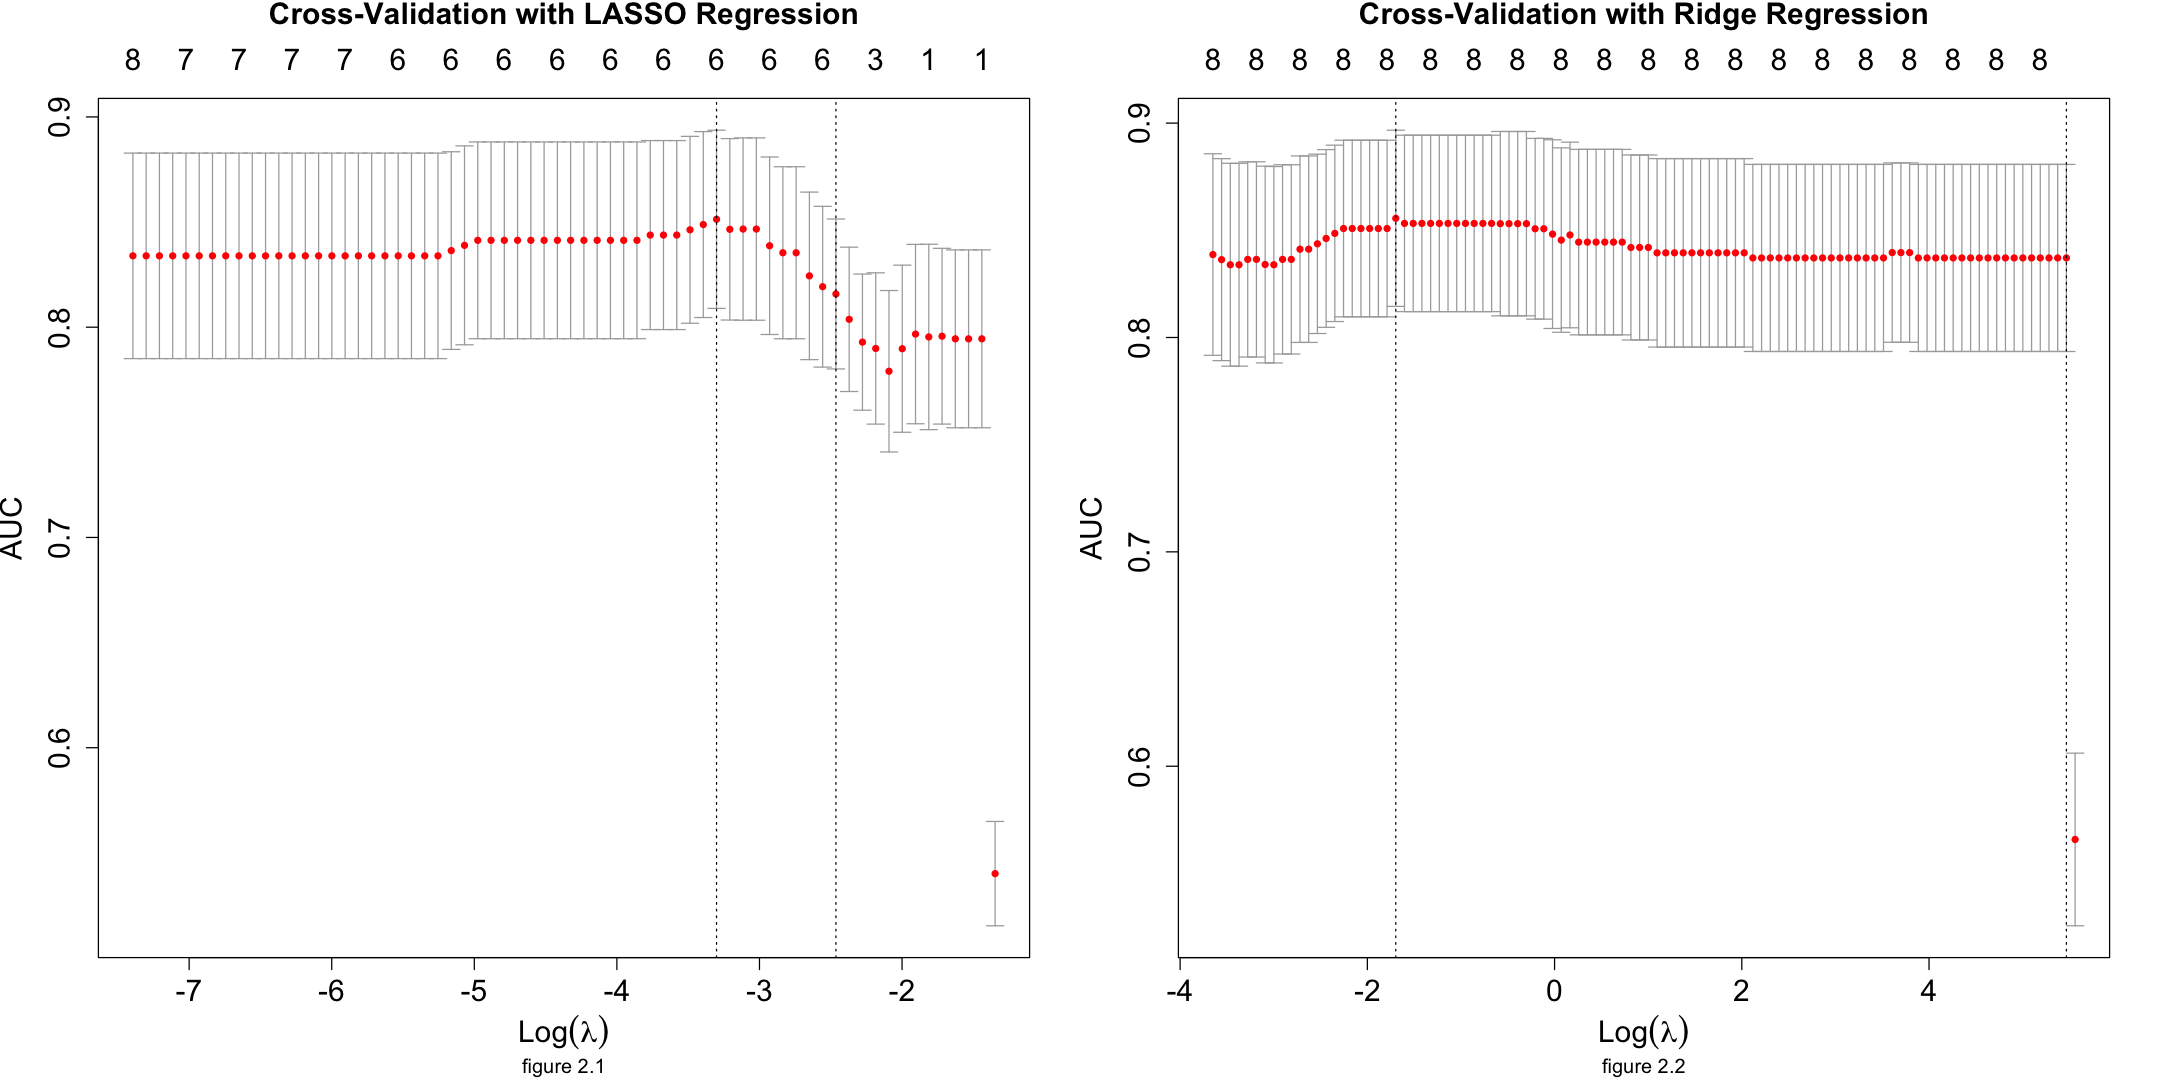

In [26]:
# Main developer: Josh
# Contributor: Yulin (rearrange plot)

options(repr.plot.width = 18, repr.plot.height = 9)
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)
par(mfrow = c(1, 2))


plot(diabetes_cv_lambda_LASSO, 
     main = "Cross-Validation with LASSO Regression\n\n",
    sub = "figure 2.1")


plot(diabetes_cv_lambda_ridge, 
     main = "Cross-Validation with Ridge Regression\n\n",
    sub = "figure 2.2")


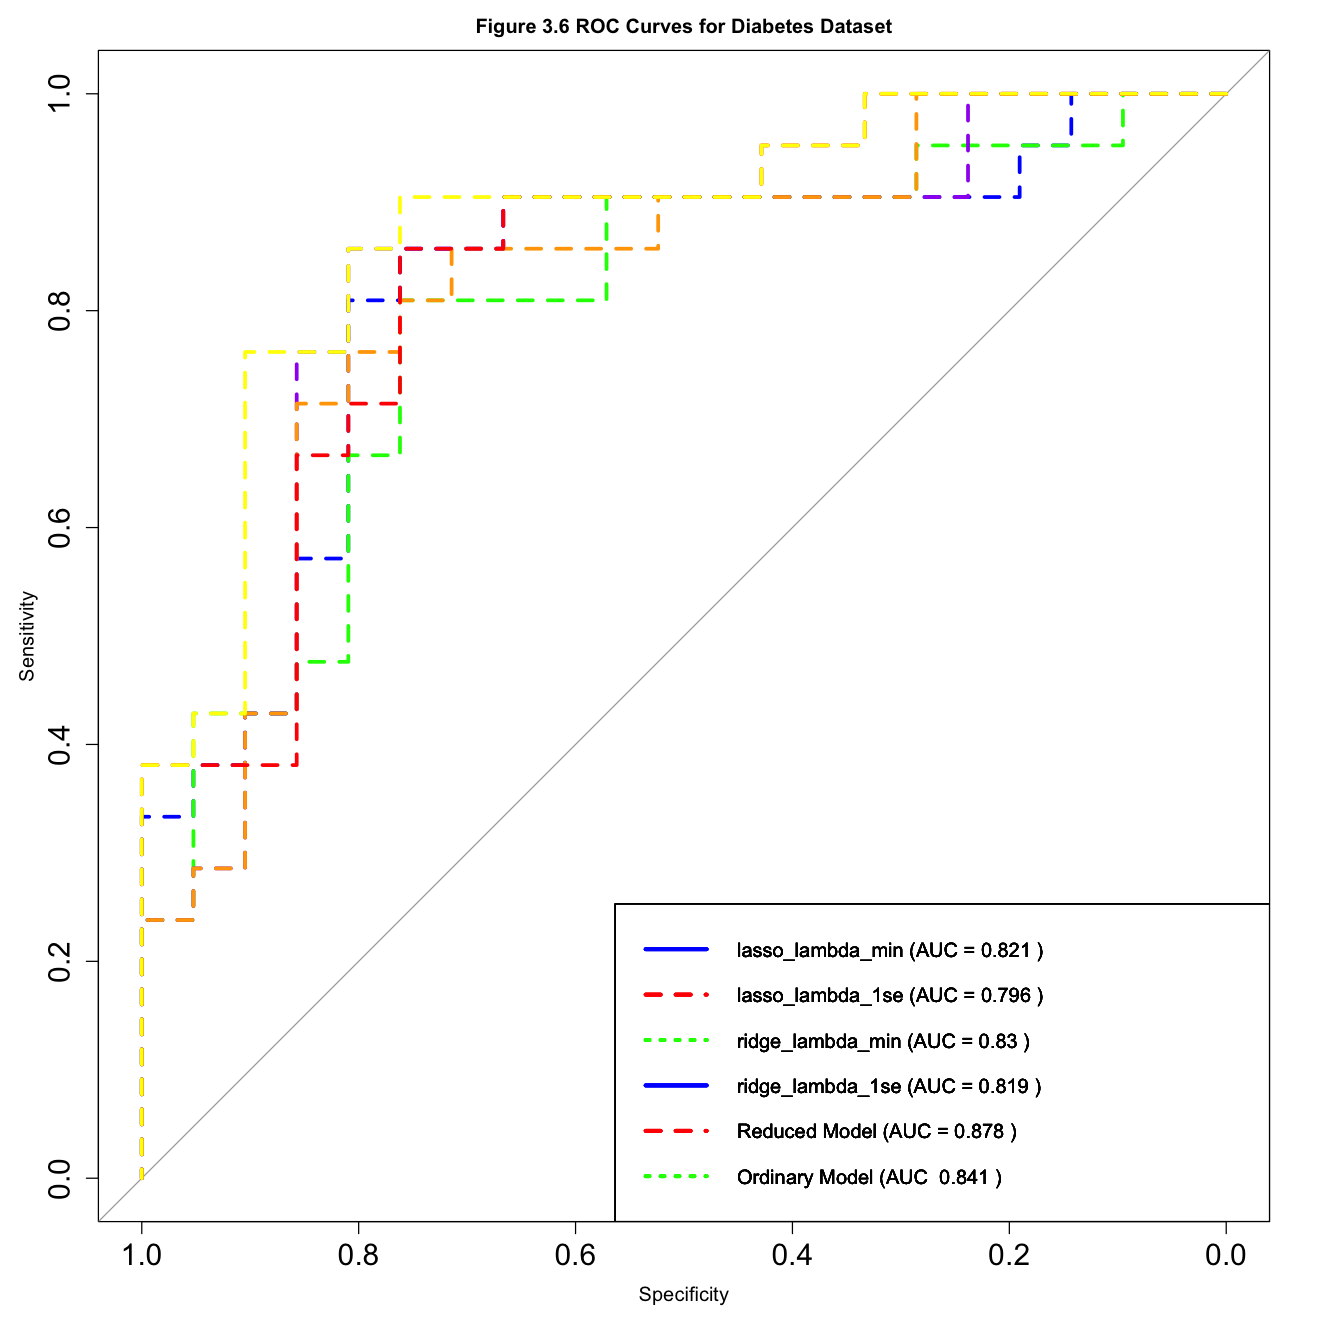

In [27]:
#Main author: Josh and Yulin
# Contributor: Farrel (Add the ordinary and reduced ROC graph)

#Roc Auc Graphs
roc_models <- list(
    lasso_lambda_min = ROC_lasso_lambda_min,
    lasso_lambda_1se = ROC_lasso_lambda_1se,
    ridge_lambda_min = ROC_ridge_lambda_min,
    ridge_lambda_1se = ROC_ridge_lambda_1se,
    ordinary = ROC_ordinary,
    reduced = ROC_reduced
)

colors <- c(
    lasso_lambda_min = "blue",
    lasso_lambda_1se = "green",
    ridge_lambda_min = "purple",
    ridge_lambda_1se = "orange",
    ordinary = "red",
    reduced = "yellow"
)

legends <- c(
    lasso_lambda_min = "Lasso (lambda.min)",
    lasso_lambda_1se = "Lasso (lambda.1se)",
    ridge_lambda_min = "Ridge (lambda.min)",
    ridge_lambda_1se = "Ridge (lambda.1se)",
    ordinary = "Ordinary",
    reduced = "Reduced"
)

options(repr.plot.width = 11, repr.plot.height = 11)
par(cex = 1, cex.lab = 1, cex.axis = 1.5, cex.main = 1)

#for loop for each model and to add figure numbers

#plotting all of the roc's in one graph

plot(
  roc_models[[1]],
  col = colors[1],
  lwd = 3,
  lty = 2,
  main = "Figure 3.6 ROC Curves for Diabetes Dataset",
  legacy.axes = FALSE
)
for (i in 2:length(roc_models)) {
  plot(
    roc_models[[i]],
    col = colors[i],
    lwd = 3,
    lty = 2,
    add = TRUE
  )
legend("bottomright",
       legend = c(
    paste("lasso_lambda_min (AUC =", round(ROC_lasso_lambda_min$auc, 3), ")"),
    paste("lasso_lambda_1se (AUC =", round(ROC_lasso_lambda_1se$auc, 3), ")"),
    paste("ridge_lambda_min (AUC =", round(ROC_ridge_lambda_min$auc, 3), ")"),
    paste("ridge_lambda_1se (AUC =", round(ROC_ridge_lambda_1se$auc, 3), ")"),
    paste("Reduced Model (AUC =", round(ROC_reduced$auc, 3), ")"),
    paste("Ordinary Model (AUC ", round(ROC_ordinary$auc, 3), ")")),
       col = c("blue", "red", "green"), 
       lwd = 3, lty = c(1, 2, 3))
    
}


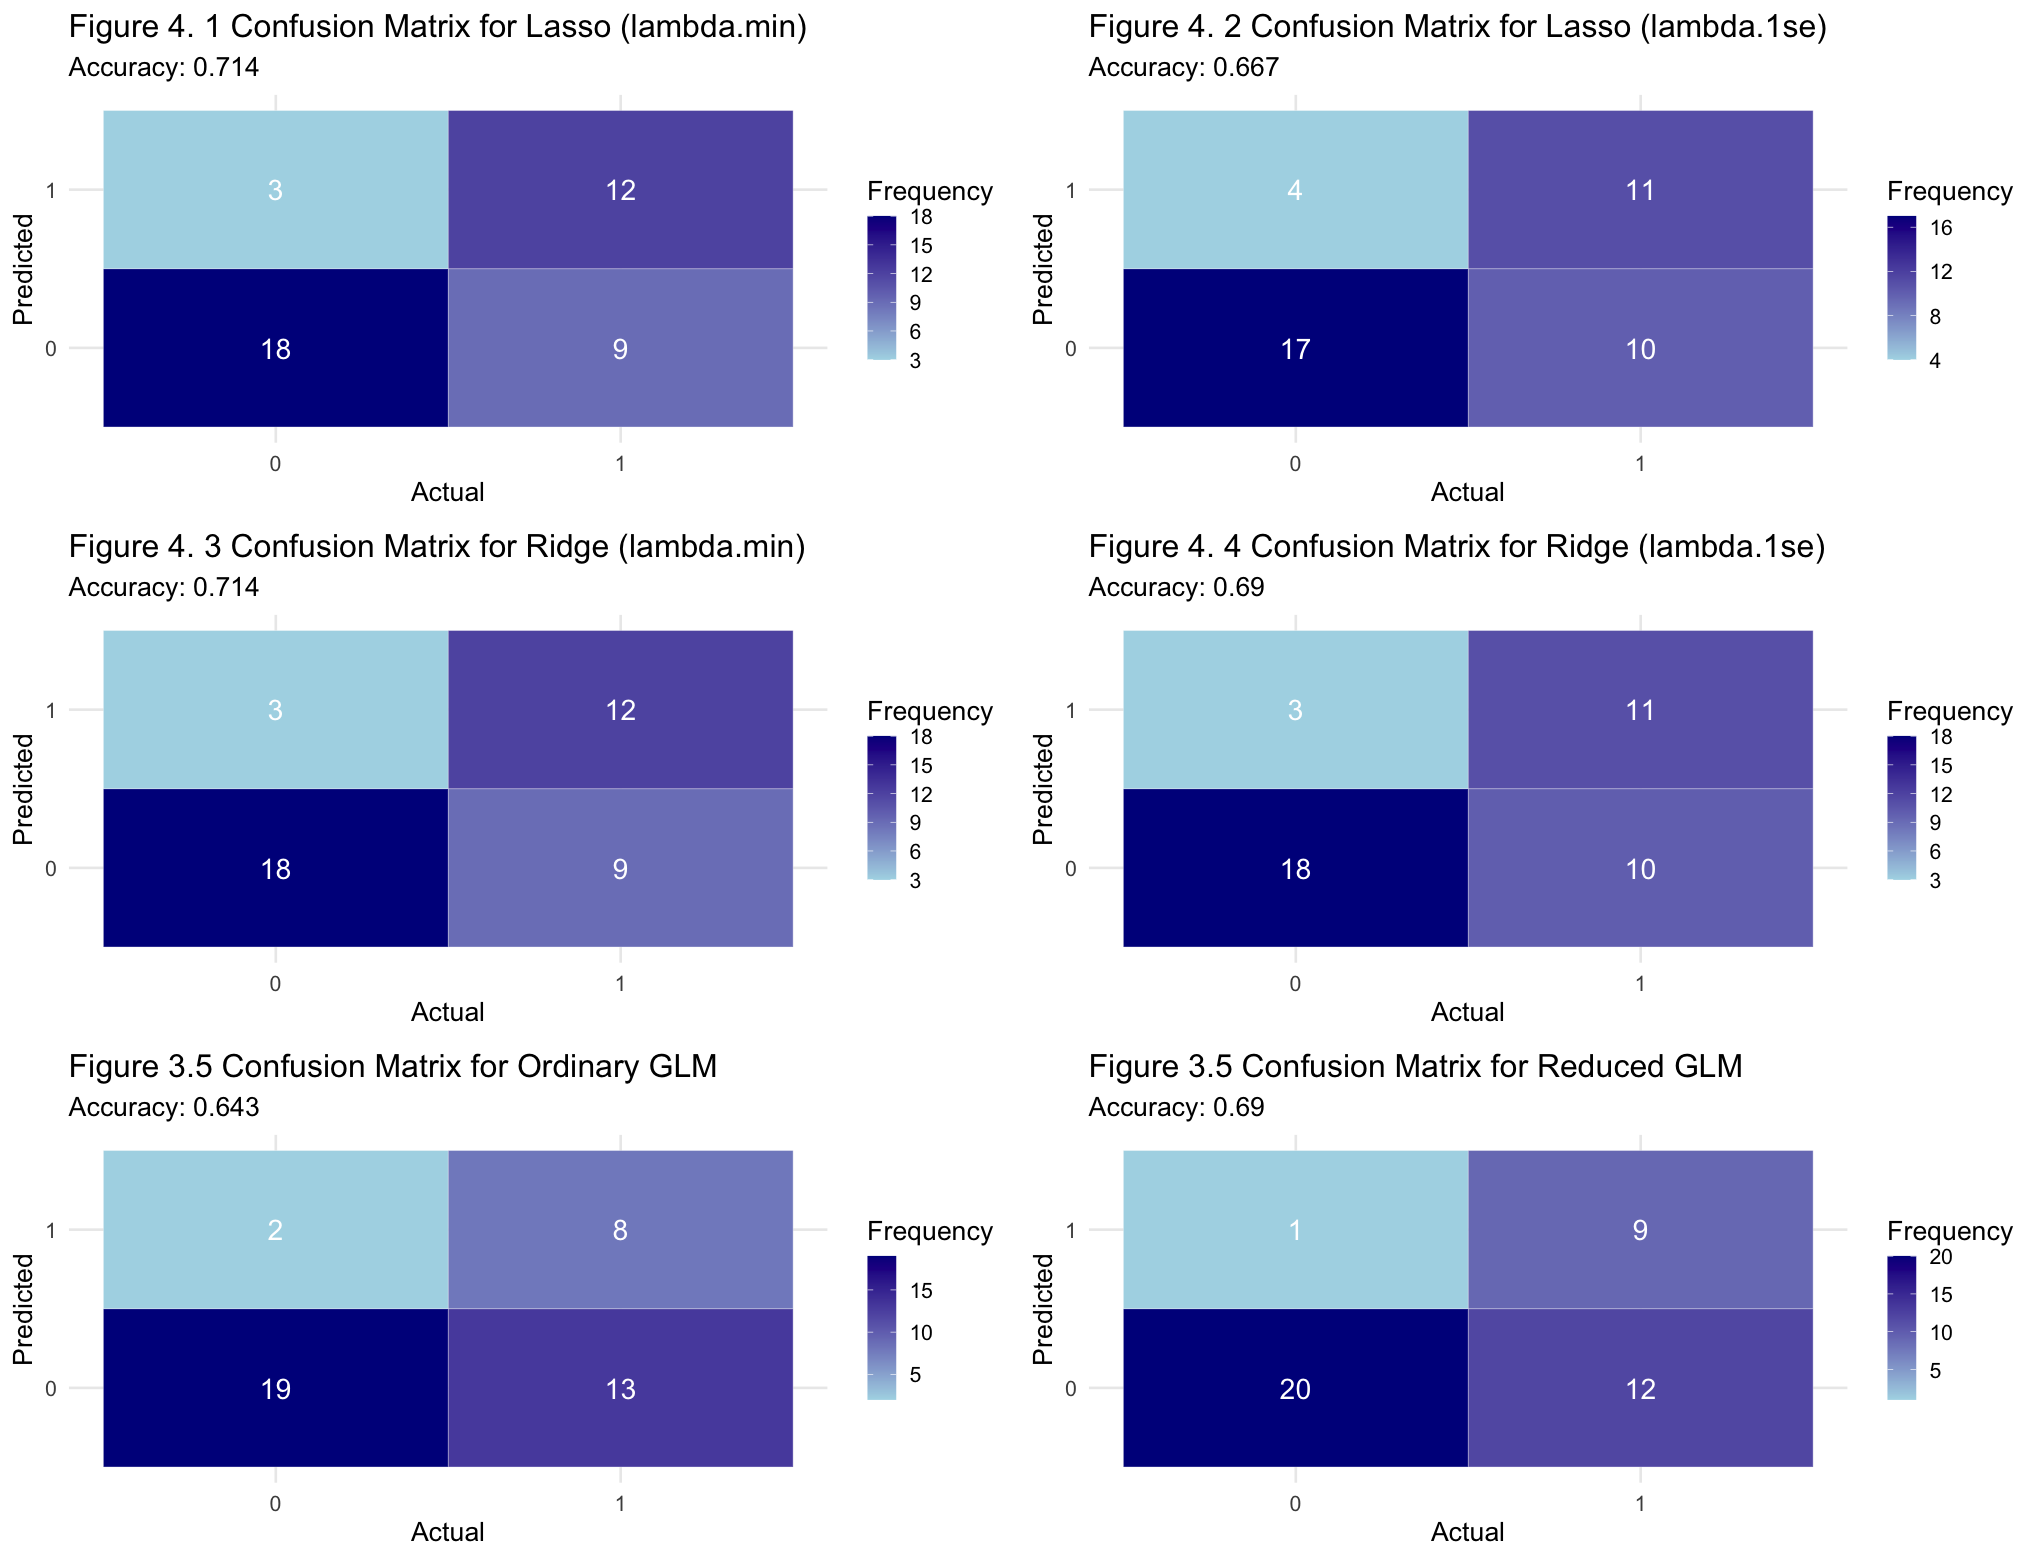

In [28]:
#Main Author : Josh
# Contributor: Farrel (Add reduced model confusion matrix)
#Making confusion matricies and testing accuracy for models
models <- list(
  diabetes_LASSO_max_AUC,
  diabetes_LASSO_1se_AUC,
  diabetes_ridge_max_AUC,
  diabetes_ridge_1se_AUC

)

model_names <- c(
  "Lasso (lambda.min)",
  "Lasso (lambda.1se)",
  "Ridge (lambda.min)",
  "Ridge (lambda.1se)"

)
plts <- list()
p_val <- 0.5
#for al lasso and ridge models
options(repr.plot.width = 17, repr.plot.height = 13)
for (i in seq_along(models)) {
  model <- models[[i]]
  model_name <- model_names[i]
  
  predicted_vals <- predict(model, newx = diabetes_X_test, type = "response")
  fitted_values <- ifelse(predicted_vals > p_val, 1, 0)
  accuracy <- mean(fitted_values == testing_diabetes$Outcome)

  confusion_m <- table(
    Predicted = factor(fitted_values, levels = c(0, 1)),
    Actual = factor(testing_diabetes$Outcome, levels = c(0, 1))
  )

  confusion_m_df <- as.data.frame(confusion_m)
  colnames(confusion_m_df) <- c("Predicted", "Actual", "Frequency")
  
  plot <- ggplot(confusion_m_df, aes(x = Actual, y = Predicted, fill = Frequency)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Frequency), color = "white", size = 6) +
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
      title = paste("Figure 4.",i,"Confusion Matrix for", model_name),
      subtitle = paste("Accuracy:", round(accuracy, 3)),  
      x = "Actual",
      y = "Predicted"
    ) +
    theme_minimal(base_size = 16)
    plts[[i]] <- plot
  
}



#ordinary glm matrix
predicted <- predict(full_diabetes_model,newdata = testing_diabetes)
  fitted <- ifelse(predicted > p_val, 1, 0)
  accuracy <- mean(fitted == testing_diabetes$Outcome)
  confusion_m <- table(
    Predicted = factor(fitted, levels = c(0, 1)),
    Actual = factor(testing_diabetes$Outcome, levels = c(0, 1))
  )

  confusion_m_df <- as.data.frame(confusion_m)
  colnames(confusion_m_df) <- c("Predicted", "Actual", "Frequency")
  glm_plt <- ggplot(confusion_m_df, aes(x = Actual, y = Predicted, fill = Frequency)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Frequency), color = "white", size = 6) +
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
      title = paste("Figure 3.5 Confusion Matrix for Ordinary GLM"),
      subtitle = paste("Accuracy:", round(accuracy, 3)),  
      x = "Actual",
      y = "Predicted"
    ) +
    theme_minimal(base_size = 16)
    plts[[5]] <- glm_plt

#reduced glm matrix
predicted <- predict(reduced_diabetes_model,newdata = testing_diabetes)
  fitted <- ifelse(predicted > p_val, 1, 0)
  accuracy <- mean(fitted == testing_diabetes$Outcome)
  confusion_m <- table(
    Predicted = factor(fitted, levels = c(0, 1)),
    Actual = factor(testing_diabetes$Outcome, levels = c(0, 1))
  )

  confusion_m_df <- as.data.frame(confusion_m)
  colnames(confusion_m_df) <- c("Predicted", "Actual", "Frequency")
  glm_plt <- ggplot(confusion_m_df, aes(x = Actual, y = Predicted, fill = Frequency)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Frequency), color = "white", size = 6) +
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
      title = paste("Figure 3.5 Confusion Matrix for Reduced GLM"),
      subtitle = paste("Accuracy:", round(accuracy, 3)),  
      x = "Actual",
      y = "Predicted"
    ) +
    theme_minimal(base_size = 16)
    plts[[6]] <- glm_plt

do.call(grid.arrange,plts)

# Discussion

# References

Bennett, P. H., Burch, T. A., & Miller, M. (2003, August 25). _Diabetes mellitus in American (PIMA) Indians_. The Lancet. https://www.sciencedirect.com/science/article/pii/S0140673671923038 

_Diabetes complications and risks_. American Heart Association. (2024, April 2). https://www.heart.org/en/health-topics/diabetes/diabetes-complications-and-risks 

_Diabetes_. World Health Organization. (2024). https://www.who.int/health-topics/diabetes#tab=tab_1 

Guan, Y., Tsai, C. J., & Zhang, S. (2024, April 5). _Research on Diabetes Prediction Model of Pima Indian Females_. Association for Computing Machinery. https://dl.acm.org/doi/abs/10.1145/3644116.3644168 

Knowler, W. C., Saad, M. F., Pettitt, D. J., Nelson, R. G., & Bennett, P. H. (1993, January 1). _Determinants of Diabetes Mellitus in the Pima Indians_. American Diabetes Association. https://diabetesjournals.org/care/article/16/1/216/20743/Determinants-of-Diabetes-Mellitus-in-the-Pima 